### Code ReadME
This code is a completion for paper: On Measuring and Controlling the Spectral Bias of the Deep Image Prior using image F16. However, I think maybe with the very large epoch number, I will be finally over-fit again. So I made this experiment

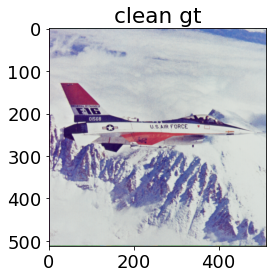

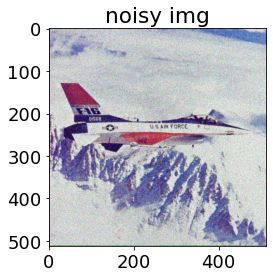

Starting optimization with ADAM


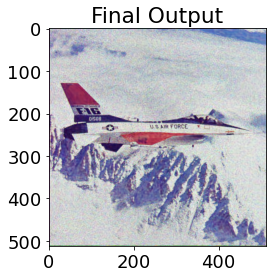

In [3]:

from __future__ import print_function
import sys

sys.path.append("..")
from module.spectual_norm_DIP import *


from skimage.metrics import peak_signal_noise_ratio
from util.measure_utils import *
from util.common_utils import *
from util.visual_utils import *
from util.gaussian_util import *
from torch.utils.tensorboard import SummaryWriter

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
### Name and path
name = 'spectual_bias_DIP_denoise_image_F16_512rgb_long_epoch'
log_path_prefix = '../log'
img_path = '../data/denoising/image_F16_512rgb.png'
save_img_path_prefix = '../output'

log_dir = os.path.join(log_path_prefix, name)
save_img_dir = os.path.join(save_img_path_prefix, name)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(save_img_dir):
    os.makedirs(save_img_dir)
writer = SummaryWriter(log_dir)
### Import data and show
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)

# noise level
sigma = 25
sigma_ = sigma / 255.
img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

plt.imshow(img_pil)
plt.title('clean gt')
plt.show()
plt.title('noisy img')
plt.imshow(img_noisy_pil)
plt.show()
### Net prepare
INPUT = 'fourier'  # 'meshgrid', 'noise', 'fourier'
var = 1
input_depth = 32
net_input = get_noise(input_depth, INPUT, (img_pil.size[1] // 32, img_pil.size[0] // 32), var=var).type(dtype).detach()

#network parameters
ln_lambda = 1.4  #the lambda in Lipschitz normalization, which is used to control spectral bias
upsample_mode = 'bilinear'  #['deconv', 'nearest', 'bilinear', 'gaussian'], where 'gaussian' denotes our Gaussian upsampling.
pad = 'reflection'
#decoder is the used network architecture in the paper
net = decoder(num_input_channels=input_depth, num_output_channels=3, ln_lambda=ln_lambda,
              upsample_mode=upsample_mode, pad=pad, need_sigmoid=True, need_bias=True).type(dtype)

#optimization parameters
OPTIMIZER = 'adam'
num_iter = 50000
LR = 0.001
reg_noise_std = 0  #1./30, injecting noise in the input.
show_every = 100

#automatic stopping
ratio_list = np.zeros((num_iter))
ratio_iter = 100  #the n in Eq. (8)
ratio_epsilon = 0.01  #the ratio difference threshold
auto_stop = False

# Loss
mse = torch.nn.MSELoss().type(dtype)
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
last_net = None
psrn_noisy_last = 0

i = 0


def closure():
    global i, out, psrn_noisy_last, last_net, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)

    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()

    psrn_noisy = peak_signal_noise_ratio(img_noisy_np, out.detach().cpu().numpy()[0])
    psrn_gt = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0])

    pre_img = out.detach().cpu().numpy()[0]
    pre_img = pre_img.transpose(1, 2, 0)
    noisy_img = img_noisy_np.transpose(1, 2, 0)

    #frequency-band correspondence metric
    avg_mask_it = get_circular_statastic(pre_img, noisy_img, size=0.2)

    #automatic stopping
    blur_it = PerceptualBlurMetric(pre_img)  #the blurriness of the output image
    sharp_it = MLVSharpnessMeasure(pre_img)  #the sharpness of the output image
    ratio_it = blur_it / sharp_it  #the ratio

    # print ('Iteration: %05d, Loss: %f, PSRN_gt: %f' % (i, total_loss.item(), psrn_gt))
    writer.add_scalar('PSNR_GT', psrn_gt, i)
    writer.add_scalar('Loss', total_loss.item(), i)
    writer.add_scalar('Mask/brand 0', avg_mask_it[0], i)
    writer.add_scalar('Mask/brand 1', avg_mask_it[1], i)
    writer.add_scalar('Mask/brand 2', avg_mask_it[2], i)
    writer.add_scalar('Mask/brand 3', avg_mask_it[3], i)
    writer.add_scalar('Mask/brand 4', avg_mask_it[4], i)
    """log_file.write('Iteration: %05d, Loss: %f, PSRN_gt: %f, mask: %s, ratio: %f\n' % (i, total_loss.item(), psrn_gt, avg_mask_it, ratio_it))
    log_file.flush()"""

    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5:
            print('Falling back to previous checkpoint., PSNR is {}'.format(psrn_noisy))

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss * 0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy

    i += 1

    return total_loss


### Train
optimize(OPTIMIZER, net.parameters(), closure, LR, num_iter)
### Model saved & output Saved
torch.save(net, os.path.join(save_img_dir, 'model.pth'))
if reg_noise_std > 0:
    net_input = net_input_saved + (noise.normal_() * reg_noise_std)
out = net(net_input)

output_img_np = torch_to_np(out)
output_img_pil = np_to_pil(output_img_np)
plt.imshow(output_img_pil)
plt.title('Final Output')
plt.show()
writer.add_image('Final Output', output_img_np)